<center><h1>Designing Agentic Systems with LangChain</h1></center>

---
# 1. The Essentials of LangChain agents


# Agents in LangChain

**Agents:** Autonomous systems that make decisions and take actions

**Tools:** Functions agents use to perform specific tasks
- Data query
- Research reports
- Data analysis 

## Create a ReAct agent

```python
# Module imports
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
import math 

# LLM Setup
model = ChatOpenAI(openai_api_key="<OPENAI_API_TOKEN>", model="gpt-4o-mini")

# Create the agent
agent = create_react_agent(model, tools)

# Create a query
query = "What is (2+8) multiplied by 9?"

# Invoke the agent and print the response
response = agent.invoke({"messages": [("human", query)]})

# Print the agent's response
print(response['messages'][-1].content)
```

---
# Building custom tools

```python
@tool
def rectangle_area(input: str) -> float:
    """Calculates the area of a 
    rectangle given the lengths of sides a and b"""
    sides = input.split(',')
    a = float(sides[0].strip())
    b = float(sides[1].strip())
    return a * b

# Define the tools that the agent can access
tools = [rectangle_area]

# Create a query using natural language
query = "What is the area of a rectangle with sides 5 and 7?"

# Pass in the hypotenuse length tool and invoke the agent
app = create_react_agent(model, tools)

# Invoke the agent and print the response
response = app.invoke({"messages": [("human", query)]})
print(response["messages"][-1].content)
```

## Pre-built and custom tools

- **Database Query**
- **Web Scraping**
- **Image Generation** 

**`Pre-built tools API guide`**

**`Custom tool guide`**

---
# Conversation with a ReAct agent

```python
tools = [rectangle_area]
query = "What is the area of a rectangle with sides 14 and 4?"

# Create the ReAct agent
app = create_react_agent(model, tools)

# Invoke the agent with a query and store the messages
response = app.invoke({"messages": [("human", query)]})

# Define and print the input and output messages
print({
    "user_input": query,
    "agent_output": response["messages"][-1].content})
```

## Conversation history

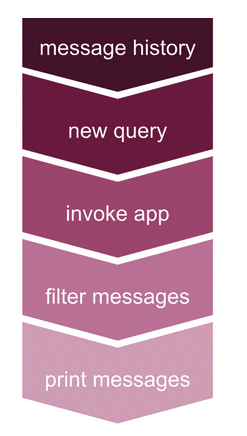

```python
from langchain_core.messages import HumanMessage, AIMessage

message_history = messages["messages"]
new_query = "What about one with sides 4 and 3?"

# Invoke the app with the full message history
messages = app.invoke({"messages":message_history + [("human", new_query)]})

# Extract the human and AI messages
filtered_messages = [msg for msg in messages["messages"] if isinstance(msg, (HumanMessage, AIMessage))
                    and msg.content.strip()]

# Format and print the final result
print({
    "user_input": new_query,
    "agent_output": [f"{msg.__class__.__name__}: {msg.content}" for msg in filtered_messages]})
```

---
# 2. Building Chatbots with LangGraph

---
# Building graphs for chatbots

**Graph State**

- Organize different tasks
    - Tool use
    - LLM calls
- Order of tasks = workflow

**Agent State**

- Tracks agent's progress
- Logs task completion 

## Building an agent with LangGraph

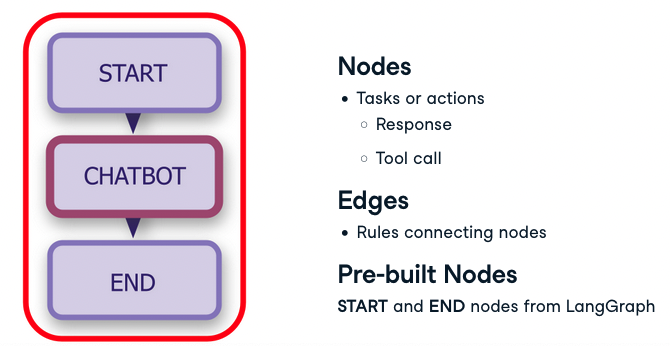


```python
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Module for setting up OpenAI
from langchain_openai import ChatOpenAI

# Define the llm
llm = ChatOpenAI(model="gpt-4o-mini", api_key="OPENAI_API_KEY")

# Define the State

class State(TypedDict):
    
    # Define messages wiht metadata
    messages: Annotated[list, add_messages]
        
# Initialize StateGraph
graph_builder = StateGraph(State)

# Define chatbot function to respond with the model
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Define the start and end of the conversation flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph to prepare for execution 
graph = graph_builder.compile()
```

---
# Generating chatbot responses

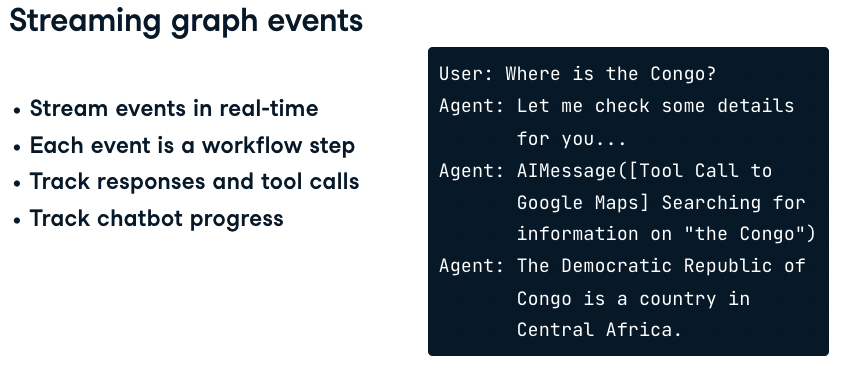

```python
# Define a function to execute the chatbot based on user input
def stream_graph_updates(user_input: str):
    
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"])
            
# Define the user query and run the chatbot
user_query = "Who is Mary Shelley?"
stream_graph_updates(user_query)
```

## Generating a LangGraph diagram

```python
# Import modules for chatbot diagram
from IPython.display import Image, display

# Try generating and displaying the graph diagram
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    
# Return an exception if necessary
except Exception:
    print("Additional dependencies required.")
```

---
# Adding external tools to a chatbot

```python
# Modules for building a Wikipedia tool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# Initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)

# Create a Wikipedia query tool using the API wrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikipedia_tool]

# Bind the Wikipedia tool to the language model
llm_with_tools = llm.bind_tools(tools)

# Modify chatbot function to respond with Wikipedia
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
```

## Adding tool nodes

```python
# Modules for adding tool conditions and nodes
from langgraph.prebuilt import ToolNode, tools_condition

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and add START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
```

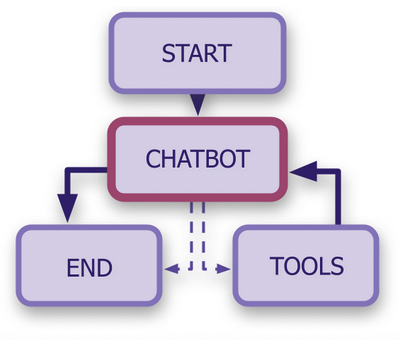

---
# Adding memory and conversation

## Testing tool use

```python
# Produce the chatbot graph
display(Image(app.get_graph().draw_mermaid_png()))

# Define a function to execute the chatbot, streaming each message
def stream_tool_responses(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Return the agent's last response
        for value in event.values():
            print("Agent:", value["messages"])
            
# Define the query and run the chatbot
user_query = "House of Lords"
stream_tool_responses(user_query)
```

## Adding memory

```python
# Import the modules for saving memory
from langgraph.checkpoint.memory import MemorySaver

# Modify the graph with memory checkpointing
memory = MemorySaver()

# Compile the graph passing in memory
graph = graph_builder.compile(checkpointer=memory)
```

## Streaming outputs with memory

```python
# Set up a streaming function for a single user

def stream_memory_responses(user_input: str):
    config = {"configurable": {"thread_id": "single_session_memory"}}
    
    # Stream the events in the graph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        
        # Return the agent's last response
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

stream_memory_responses("What is the Colosseum?")
stream_memory_responses("Who built it?")
```

---
# 3. Build Dynamic Chat Agents

---
# Defining multiple tools

## Historical events tool

```python
# Use a decorator to label the tool and set the input format to string

@tool
def date_checker(date: str) -> str:
    """Provide a list of important historical events for a given date in any format."""
    try:
        # Invoke the LLM to interpret the date and generate historical events
        answer = llm.invoke(f"List important historical events that occurred on {date}.")
        
        # Return the response
        return answer.content
    
    # Set an exception block for errors in retrieval
    except Exception as e:
        return f"Error retrieving events: {str(e)}"
```

## Palindrome tool

```python
@tool
# Set input format to string
def check_palindrome(text:str):
    """Check if a word or phrase is a palindrome."""
    
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned = ''.join(char.lower() for char in text if char.isalnum())
    
    # Check if the reversed text is the same as original text
    if cleaned == cleaned[::-1]:
        return f"The phrase or word '{text}' is a palindrome."
    else:
        return f"The phrase or word '{text}' is not a palindrome."
```

## Binding multiple tools

```python
# Import modules required for defining tool nodes
from langgraph.prebuilt import ToolNode

# List of tools
tools = [wikipedia_tool, date_checker, check_palindrome]

# Pass the tools to the ToolNode()
tool_node = ToolNode(tools)

# Bind tools to the LLM
model_with_tools = llm.bind_tools(tools)
```

---
# Defining nodes and edges for flexible function calling

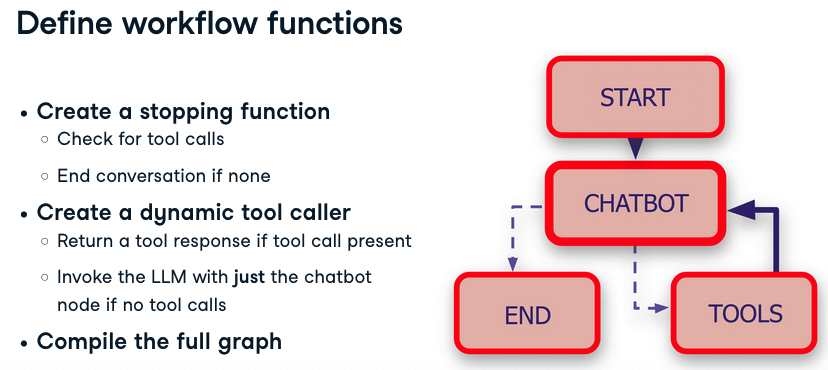

## Create a stop condition function

```python
from langgraph.graph import MessagesState, START, END

# Use MessagesState to define the state of the stopping function
def should_continue(state: MessagesState):
    
    # Get the last message from the state
    last_message = state["messages"][-1]
    
    # Check if the last message includes tool calls
    if last_message.tool_calls:
        return "tools"
    
    # End the conversation if no tool calls are present
    return END 
        
```

## Create a dynamic tool caller

```python
# Extract the last message from the history
def call_model(state: MessagesState):
    last_message = state["messages"][-1]
    
    # If the last message has tool calls, return the tool's response
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        
        # Return the messages from the tool call
        return {"messages": [AIMessage(content=last_message.tool_calls[0]["response"])]}
    
    # Otherwise, proceed with a regular LLM response
    return {"messages": [model_with_tools.invoke(state["messages"])]}
```

## Create the graph

```python
workflow = StateGraph(MessagesState)

# Add nodes for chatbot and tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Connect the START node to the chatbot
workflow.add_edge(START, "chatbot")

# Define conditions, then loop back to chatbot
workflow.add_conditional_edges("chatbot", should_continue, ["tools", END])
workflow.add_edge("tools", "chatbot")
```

## Adding memory
```python
# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))
```

---
# Organize chatbot outputs with memory

## Streaming multiple tool outputs

```python
from langchain_core.messages import AIMessage, HumanMessage

config = {"configurable": {"thread_id": "1"}}

# Create input message with the user's query
def multi_tool_output(query):
    inputs = {"messages": [HumanMessage(content=query)]}
    
    # Stream messages and metadata from the chatbot application
    for msg, metadata in app.stream(inputs, config, stream_mode="messages"):
        
        # Check if the message has content and is not from a human
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="", flush=True)
            
    print("\n")
```

## Test with multiple tools 

Check dynamic tool alignment

```python
multi_tool_output("Is `Stella won no wallets` a palindrome?")
multi_tool_output("What happened on April 12th, 1955?")
```

## Follow-up questions with multiple tools

```python
# Print the user query first for every interaction

def user_agent_multiturn(queries):
    for query in queries:
        print(f"User: {query}")
        
        # Stream through messages corresponding to queries, excluding metadata
        print("Agent: " + "".join(msg.content for msg, metadata in app.stream(
        {"messages": [HumanMessage(content=query)]}, config, stream_mode="messages")
           
                 # Filter out the human messages to print agent messages
                 if msg.content and not isinstance(msg, HumanMessage)) + "\n")
        
queries = ["What happened on the 12 April 1961?", "What about 10 December 1948?",
          "Is `Mr. Owl ate my metal worm?` a palindrome?", "What about `palladium stadium?`"]

user_agent_multiturn(queries)
```